# Lab 14: Playing Atari games with Deep Reinforcement Learning

Material for this lab comes from these sources:
 - Pytorch 1.x Reinforcement Learning Cookbook (Packtpub)
 - Hands-On Reinforcement Learning for Games (Packtpub)

## Deep Q-Learning

Last time we implemented Q learning and made a first attempt at replacing the Q table with a deep neural network.

A deep Q-Network (DQN) is similar to a supervised regression model $F_{\theta}$, but it more specifically maps states to action values directly instead of using a set of features.

A DQN is trained to output $Q(s,a)$ values for each action given the input state $s$. In operation, in state $s$, the action $a$ is chosen greedily based on $Q(s,a)$ or stochastically
following an epsilon-greedy policy.

<img src="img/RL2_DQN.png" title="DQN" style="width: 800px;" />

In tabular Q learning, the update rule is an off-policy TD learning rule. When we take
action $a$ in state $s$ receiving reward $r$, we update $Q(s,a)$ as

$$Q(s,a)=Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a')-Q(s,a)),$$

where
 - $s'$ is the resulting state after taking action $a$ in state $s$
 - $\max_{a'}Q(s',a')$ is value of the action $a'$ we would take in state $s'$ according to a greedy behavior policy.

A DQN does the same thing using backpropagation, minimizing inconsistencies in its $Q$ estimates. At each step, the difference
between the estimated value and the observed data from the subsequent step should be minimized, giving us a kind of regression
problem, for which a squared error loss function is appopriate, giving us a delta for the $a$th output of

$$\delta_a=r+\gamma\max_{a'}Q(s')_{a'}-Q(s)_{a}.$$

With an appropriate exploration strategy and learning rate, DQN should find the optimal network model best approximating
the state-value function $Q(s,a)$ for each possible state and action.

## DQN Example: Cartpole

Let's develop a sample DQN application step by step. First, some imports we'll need.
We'll use the `gym` package like last week.

In [2]:
import math, random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

import matplotlib.pyplot as plt

import gym
import numpy as np

from collections import deque
from tqdm import trange

# Select GPU or CPU as device

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### $\epsilon$ decay schedule

Recall that some of the theoretical results on TD learning assume $\epsilon$-greedy exploration with $\epsilon$ decaying slowly to 0
over time. Let's define an exponential decay schedule for $\epsilon$. First, an example:


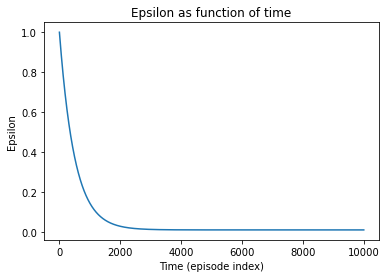

In [8]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

# Define epsilon as a function of time (episode index)

eps_by_episode = lambda episode: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * episode / epsilon_decay)

# Note that the above lambda expression is equivalent to explicitly defining a function:
# def epsilon_episode(episode):
#     return epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * episode / epsilon_decay)

plt.plot([eps_by_episode(i) for i in range(10000)])
plt.title('Epsilon as function of time')
plt.xlabel('Time (episode index)')
plt.ylabel('Epsilon')
plt.show()


Here's a reusable function to generate an annealing schedule function according to given parameters:

In [9]:
# Epsilon annealing schedule generator

def gen_eps_by_episode(epsilon_start, epsilon_final, epsilon_decay):
    eps_by_episode = lambda episode: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * episode / epsilon_decay)
    return eps_by_episode

epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500
eps_by_episode = gen_eps_by_episode(epsilon_start, epsilon_final, epsilon_decay)

### Replay buffer

We know that deep learning methods learn faster when training samples are combined into batches. This speeds up learning and also makes it more stable by averaging
updates over multiple samaples.

RL algorithms also benefit from batched training. However, we see that the standard Q learning rule always updates $Q$ estimates using the most recent experience.
If we always trained on batches consisting of samples of the most recent behavior, correlations between successive state action pairs will make learning less effective.
So we would also like to select random training samples to make them look more like the i.i.d. sampling that supervised learning performs well under.

In RL, the standard way of doing this is to create a large buffer of past state action pairs then form training batches by sampling from that replay buffer.
Our replay buffer will store tuples consisting of an observed state, an action, the next_state, the reward, and the termination signal obtained by the agent at that point in time:

In [12]:
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        # Add batch index dimension to state representations
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

### Basic DQN

Next, a basic DQN class. We just create a neural network that takes as input a state
and returns an output vector indiciating the value of each possible action $Q(s,a)$.

The steps we take during learning will be as follows:

<img src="img/RL2_DQNstep.jpeg" title="" style="width: 600px;" />

To implement the policy, besides the usual `forward()` method, we add one additional method `act()`,
which samples an $\epsilon$-greedy action for state $s$ using the current estimate $Q(s,a)$.
`act()` will be used to implement step 1 in the pseudocode above.


In [13]:
class DQN(nn.Module):
    
    def __init__(self, n_state, n_action):
        super(DQN, self).__init__()        
        self.layers = nn.Sequential(
            nn.Linear(n_state, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_action)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        # Get an epsilon greedy action for given state
        if random.random() > epsilon: # Use argmax_a Q(s,a)
            state = autograd.Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True).to(device)
            q_value = self.forward(state)
            q_value = q_value.cpu()
            action = q_value.max(1)[1].item()            
        else: # get random action
            action = random.randrange(env.action_space.n)
        return action

### Create gym environment, prepare DQN for training

Next we set up a gym environment for the cartpole simulation, create a DQN model with Adam optimization, and create a replay buffer of length 1000.

In [14]:
env_id = "CartPole-v0"
env = gym.make(env_id)

model = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
    
optimizer = optim.Adam(model.parameters())

replay_buffer = ReplayBuffer(1000)

### Training step

In the training step, we sample a batch from the replay buffer, calculate $Q(s,a)$ and $\max_{a'} Q(s',a')$, calculate
the target $Q$ value $r + \gamma\max_{a'}Q(s',a')$, the mean squared loss between the predicted and target $Q$ values,
and then backpropagate.


In [15]:
def compute_td_loss(model, batch_size, gamma=0.99):

    # Get batch from replay buffer
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    # Convert to tensors. Creating Variables is not necessary with more recent PyTorch versions.
    state      = autograd.Variable(torch.FloatTensor(np.float32(state))).to(device)
    next_state = autograd.Variable(torch.FloatTensor(np.float32(next_state)), volatile=True).to(device)
    action     = autograd.Variable(torch.LongTensor(action)).to(device)
    reward     = autograd.Variable(torch.FloatTensor(reward)).to(device)
    done       = autograd.Variable(torch.FloatTensor(done)).to(device)

    # Calculate Q(s) and Q(s')
    q_values      = model(state)
    next_q_values = model(next_state)

    # Get Q(s,a) and max_a' Q(s',a')
    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    # Calculate target for Q(s,a): r + gamma max_a' Q(s',a')
    # Note that the done signal is used to terminate recursion at end of episode.
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    # Calculate MSE loss. Variables are not needed in recent PyTorch versions.
    loss = (q_value - autograd.Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

### Plot rewards and losses

Here's a little function to plot relevant details for us:

In [16]:
def plot(episode, rewards, losses):
    # clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('episode %s. reward: %s' % (episode, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)   
    plt.show() 

### Training loop

The training loop lets the agent play the game until the end of the episode.
Each step is appended to the replay buffer. We don't do any learning until the buffer's length reaches the batch_size.


In [17]:
def train(env, model, eps_by_episode, optimizer, replay_buffer, episodes = 10000, batch_size=32, gamma = 0.99):
    losses = []
    all_rewards = []
    episode_reward = 0
    tot_reward = 0
    tr = trange(episodes+1, desc='Agent training', leave=True)

    # Get initial state input
    state = env.reset()

    # Execute episodes iterations
    for episode in tr:
        tr.set_description("Agent training (episode{}) Avg Reward {}".format(episode+1,tot_reward/(episode+1)))
        tr.refresh() 

        # Get initial epsilon greedy action
        epsilon = eps_by_episode(episode)
        action = model.act(state, epsilon)
        
        # Take a step
        next_state, reward, done, _ = env.step(action)

        # Append experience to replay buffer
        replay_buffer.push(state, action, reward, next_state, done)

        tot_reward += reward
        episode_reward += reward
        
        state = next_state

        # Start a new episode if done signal is received
        if done:
            state = env.reset()
            all_rewards.append(episode_reward)
            episode_reward = 0

        # Train on a batch if we've got enough experience
        if len(replay_buffer) > batch_size:
            loss = compute_td_loss(model, batch_size, gamma)
            losses.append(loss.item())
            
    plot(episode, all_rewards, losses)  
    return model,all_rewards, losses

### Train!

Let's train our DQN model for 10,000 steps in the cartpole simulation:

Agent training (episode33) Avg Reward 0.9696969696969697:   0%|          | 0/10001 [00:00<?, ?it/s]<ipython-input-15-4a879285f6b4>:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  next_state = autograd.Variable(torch.FloatTensor(np.float32(next_state)), volatile=True).to(device)
Agent training (episode53) Avg Reward 0.9811320754716981:   0%|          | 33/10001 [00:00<03:42, 44.88it/s]<ipython-input-13-d0bb01164c5d>:19: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  state = autograd.Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True).to(device)
Agent training (episode10001) Avg Reward 0.9999000099990001: 100%|██████████| 10001/10001 [00:35<00:00, 285.34it/s]


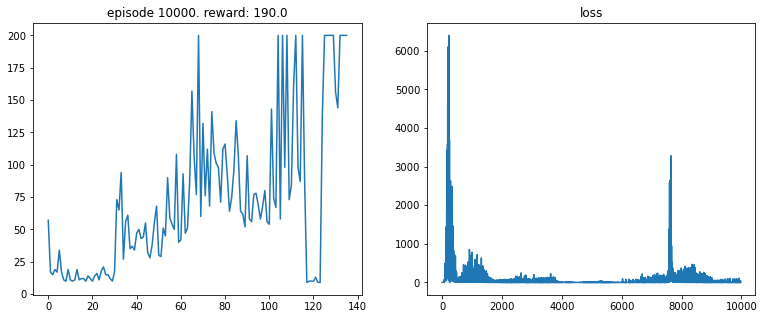

In [18]:
model,all_rewards, losses = train(env, model, eps_by_episode, optimizer, replay_buffer, episodes = 10000, batch_size=32, gamma = 0.99)

### Play in the simulation

You can run your simulation in Jupyter if you have OpenGL installed, but after the simulation is finished, you must close the
simulator with `env.close()` (this closes the simulator, not the environment).

In [ ]:
import time
def play_game(model):
    done = False
    state = env.reset()
    while(not done):
        action = model.act(state, epsilon_final)
        next_state, reward, done, _ = env.step(action)
        env.render()
        time.sleep(0.03)
        state = next_state

play_game(model)
time.sleep(3)
env.close()

## Other games

You can learn to control players of other games such as Lunar Lander with the
same model.

You may need to install swig and box2d-py:

    conda install swig # needed for box2d-py
    pip install box2d-py # a repackaged version of pybox2d

Note: to install swig, [follow these instructions](https://www.dev2qa.com/how-to-install-swig-on-macos-linux-and-windows).

In [ ]:
env_id = 'LunarLander-v2'
env = gym.make(env_id)

model = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
    
optimizer = optim.Adam(model.parameters())

replay_buffer = ReplayBuffer(1000)

Agent training (episode10001) Avg Reward -0.41349290554965085: 100%|██████████| 10001/10001 [00:34<00:00, 289.74it/s]


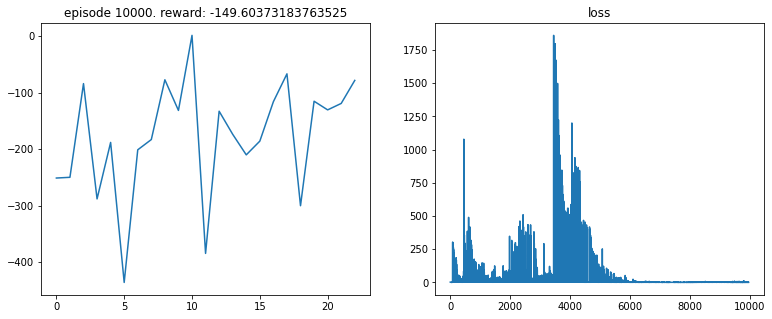

In [16]:
model, all_rewards, losses = train(env, model, eps_by_episode, optimizer, replay_buffer, episodes = 10000, batch_size=32, gamma = 0.99)

In [17]:
play_game(model)
time.sleep(3)
env.close()

## Applying DQN to Atari games

How about Atari games? It's possible as we
saw from the Mnih et al. (2015) paper in *Nature*, but since the game has *images* as inputs, we have to from image inputs to look like states
to the DQN model.

In the example below, we get a state image, convert to grayscale, and reshape it into a 1D vector for input to the DQN class.

Let's play *Pong*, the first commercially successful video game.

In [ ]:
env_id = 'PongDeterministic-v4'
env = gym.make(env_id)

Pong has 6 possible actions. You can check the meaning of each action as below:

In [19]:
print(env.unwrapped.get_action_meanings())
print(env.observation_space.shape)

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
(210, 160, 3)


Here's a screen processing function to downsize the image and convert to grayscale:

In [13]:
import torchvision.transforms as T
from PIL import Image
image_size = 84

transform = T.Compose([T.ToPILImage(),  # from tensors to image data
                       T.Grayscale(num_output_channels=1), # convert to grayscale with 1 channel
                       T.Resize((image_size, image_size), interpolation=Image.CUBIC), # resize to 84*84 by using Cubic interpolation
                       T.ToTensor()]) # convert back to tensor

def get_state(observation):
    # Numpy: Use transpose(a, argsort(axes)) to invert the transposition of tensors when using the axes keyword argument.
    # Example: x = np.ones((1, 2, 3))
    # np.transpose(x, (1, 0, 2)).shape --> (2, 1, 3)
    state = observation.transpose((2,0,1))
    state = torch.from_numpy(state)
    state = transform(state)
    return state

Let's change the DQN input to be an 84$\times$84 image:

In [21]:
model = DQN(image_size * image_size, env.action_space.n).to(device)
    
optimizer = optim.Adam(model.parameters())

replay_buffer = ReplayBuffer(1000)

model

DQN(
  (layers): Sequential(
    (0): Linear(in_features=7056, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=6, bias=True)
  )
)

We have to modify the training function a bit:

In [14]:
def train2(env, model, eps_by_episode, optimizer, replay_buffer, episodes = 10000, batch_size=32, gamma = 0.99):
    losses = []
    all_rewards = []
    episode_reward = 0

    obs = env.reset()
    # convert observation state to image state, and reshape as 1D size
    state = get_state(obs).view(image_size * image_size)
    ######################################################
    tot_reward = 0
    tr = trange(episodes+1, desc='Agent training', leave=True)
    for episode in tr:
        tr.set_description("Agent training (episode{}) Avg Reward {}".format(episode+1,tot_reward/(episode+1)))
        tr.refresh() 

        # get action with q-values
        epsilon = eps_by_episode(episode)
        action = model.act(state, epsilon)
        
        # input action into state
        next_obs, reward, done, _ = env.step(action)
        # convert observation state to image state, and reshape as 1D size
        next_state = get_state(next_obs).view(image_size * image_size)
        ###################################################################
        # save data into buffer
        replay_buffer.push(state, action, reward, next_state, done)

        tot_reward += reward
        
        state = next_state
        obs = next_obs
        episode_reward += reward
        
        if done:
            obs = env.reset()
            # convert observation state to image state, and reshape as 1D size
            state = get_state(obs).view(image_size * image_size)
            ###################################################################
            all_rewards.append(episode_reward)
            episode_reward = 0
            
        if len(replay_buffer) > batch_size:
            loss = compute_td_loss(model, batch_size, gamma)
            losses.append(loss.item())
            
    plot(episode, all_rewards, losses)  
    return model,all_rewards, losses

Agent training (episode10001) Avg Reward -0.0254974502549745: 100%|██████████| 10001/10001 [00:42<00:00, 237.29it/s]


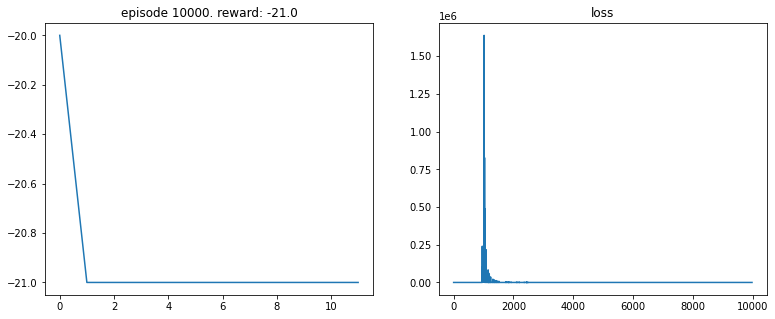

In [23]:
model, all_rewards, losses = train2(env, model, eps_by_episode, optimizer, replay_buffer, episodes = 10000, batch_size=32, gamma = 0.99)

### Simulate pong

In [15]:
def play_game2(model):
    done = False
    obs = env.reset()
    # convert observation state to image state, and reshape as 1D size
    state = get_state(obs).view(image_size * image_size)
    #################################################################
    while(not done):
        action = model.act(state, epsilon_final)
        next_obs, reward, done, _ = env.step(action)
        # convert observation state to image state, and reshape as 1D size
        next_state = get_state(next_obs).view(image_size * image_size)
        #################################################################
        env.render()
        time.sleep(0.03)
        state = next_state

In [26]:
play_game2(model)
time.sleep(3)
env.close()

Wooooo! How easy!!!

## Other Atari games: Space Invaders

Now let's try Space Invaders.

Agent training (episode71) Avg Reward 0.07042253521126761:   0%|          | 48/20001 [00:00<00:42, 466.47it/s]['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
(210, 160, 3)
Agent training (episode20001) Avg Reward 0.11924403779811009: 100%|██████████| 20001/20001 [01:23<00:00, 239.11it/s]


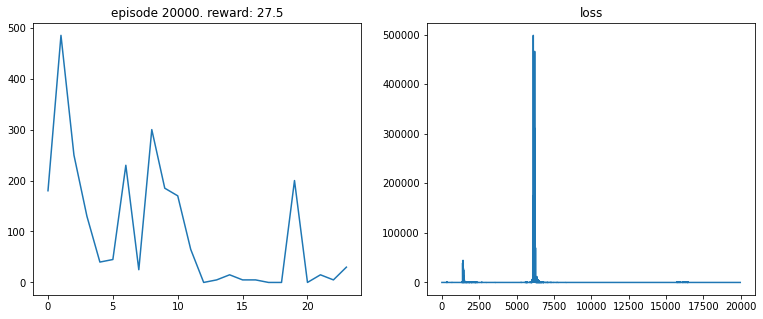

In [28]:
env_id = 'SpaceInvaders-v0'
env = gym.make(env_id)

print(env.unwrapped.get_action_meanings())
print(env.observation_space.shape)


model = DQN(image_size * image_size, env.action_space.n).to(device)
    
optimizer = optim.Adam(model.parameters())

replay_buffer = ReplayBuffer(1000)

model, all_rewards, losses = train2(env, model, eps_by_episode, optimizer, replay_buffer, episodes = 20000, batch_size=32, gamma = 0.99)

In [30]:
play_game2(model)
time.sleep(3)
env.close()

## CNN based DQNs for Atari games

In Atari games, we have image as state observation input. At first, we just converted the image to grayscale and flattened it.
This loses spatial information, of course. We know we should use the image input and process it as a CNN in our DQN model.

We'll just resize image, leaving the RGB color in the image, leaving the input channels as 3:

<img src="img/RL2_CNNDQN.png" title="" style="width: 800px;" />

In [16]:
transform = T.Compose([T.ToPILImage(),
                       T.Resize((image_size, image_size), interpolation=Image.CUBIC),
                       T.ToTensor()])

# Convert to RGB image (3 channels)

def get_state2(observation):
    state = observation.transpose((2,0,1))
    state = torch.from_numpy(state)
    state = transform(state)
    return state

# Train the DQN CNN

def train_CNNDQN(env, model, eps_by_episode, optimizer, replay_buffer, episodes = 10000, batch_size=32, gamma = 0.99):
    losses = []
    all_rewards = []
    episode_reward = 0

    obs = env.reset()
    # change from get_state to get_state2
    state = get_state2(obs)
    tot_reward = 0
    tr = trange(episodes+1, desc='Agent training', leave=True)
    for episode in tr:
        tr.set_description("Agent training (episode{}) Avg Reward {}".format(episode+1,tot_reward/(episode+1)))
        tr.refresh() 

        # get action with q-values
        epsilon = eps_by_episode(episode)
        action = model.act(state, epsilon)
        
        # input action into state
        next_obs, reward, done, _ = env.step(action)
        # change from get_state to get_state2
        next_state = get_state2(next_obs)
        # save data into buffer
        replay_buffer.push(state, action, reward, next_state, done)

        tot_reward += reward
        
        state = next_state
        obs = next_obs
        episode_reward += reward
        
        if done:
            obs = env.reset()
            # change from get_state to get_state2
            state = get_state2(obs)
            all_rewards.append(episode_reward)
            episode_reward = 0
            
        if len(replay_buffer) > batch_size:
            loss = compute_td_loss(model, batch_size, gamma)
            losses.append(loss.item())
            
    plot(episode, all_rewards, losses)  
    return model, all_rewards, losses

### Create the CNN DQN

We have the following characteristics:
- Input channels: 3 (RGB channels)
- Ouput: all possible actions

In [18]:
class CNNDQN(nn.Module):
    def __init__(self, n_channel, n_action):
        super(CNNDQN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=n_channel, out_channels=32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)
        self.fc1= nn.Linear(7*7*64, 512)
        self.fc2= nn.Linear(512, n_action)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def act(self, state, epsilon):
        # get action from policy action and epsilon greedy
        if random.random() > epsilon: # get action from old q-values
            state   = autograd.Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True).to(device)
            q_value = self.forward(state)
            q_value = q_value.cpu()
            action  = q_value.max(1)[1].item()            
        else: # get random action
            action = random.randrange(env.action_space.n)
        return action

env_id = 'SpaceInvaders-v0'
env = gym.make(env_id)

print(env.unwrapped.get_action_meanings())
print(env.observation_space.shape)

model = CNNDQN(3, env.action_space.n).to(device)
    
optimizer = optim.Adam(model.parameters())

replay_buffer = ReplayBuffer(1000)

model, all_rewards, losses = train_CNNDQN(env, model, eps_by_episode, optimizer, replay_buffer, episodes = 50000, batch_size=32, gamma = 0.99)

### Modify simulator to support CNN DQNs

Let's modify our simulator interface to accept a CNN DQN model:

In [19]:
def play_game_CNN(model):
    done = False
    obs = env.reset()
    state = get_state(obs)
    while(not done):
        action = model.act(state, epsilon_final)
        next_obs, reward, done, _ = env.step(action)
        next_state = get_state2(next_obs)
        env.render()
        time.sleep(0.1)
        state = next_state

In [42]:
play_game_CNN(model)
time.sleep(3)
env.close()

## Double DQN

The Double DQN is is a deep learning version of
the double Q learning algorithm. The idea is to use one DQN for
learning and another DQN to provide the learning targets, making learning
more stable. The double DQN was introduced by, you guessed it, Google DeepMind, again!
You can read the details in [the double DQN paper](https://arxiv.org/pdf/1509.06461.pdf).

The two networks are called the prediction network and the target network. The learning rule is

$$\delta=r+\gamma\max_a Q_T(s',a':\theta_t^-) - Q(s).$$

$Q_T$ is the target generating network, and $Q$ is the prediction network. 

In [27]:
env_id = 'SpaceInvaders-v0'
env = gym.make(env_id)

current_model = CNNDQN(3, env.action_space.n).to(device)
target_model = CNNDQN(3, env.action_space.n).to(device)

optimizer = optim.Adam(current_model.parameters())
replay_buffer = ReplayBuffer(1000)

### Update target model weights

In [28]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

# Initialization

update_target(current_model, target_model)

### Modify training step for double DQN

In [29]:
def compute_td_loss_DoubleDQN(current_model, target_model, batch_size, gamma=0.99):     # from input only a model, you must input 2 models: current_model, and target_model
    # get data from replay mode
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    # convert to tensors
    # Autograd automatically supports Tensors with requires_grad set to True.
    state      = autograd.Variable(torch.FloatTensor(np.float32(state))).to(device)
    next_state = autograd.Variable(torch.FloatTensor(np.float32(next_state)), volatile=True).to(device)
    action     = autograd.Variable(torch.LongTensor(action)).to(device)
    reward     = autograd.Variable(torch.FloatTensor(reward)).to(device)
    done       = autograd.Variable(torch.FloatTensor(done)).to(device)

    # calculate q-values and next q-values from deeplearning
    q_values      = current_model(state)
    next_q_values = current_model(next_state)
    # double DQN add here
    next_q_state_values = target_model(next_state)
    ############################################################

    # get q-value from propagated action in each step
    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    # double DQN different here
    next_q_value     = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
    ############################################################################
    # calculate expected q-value from q-function
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    # calculate loss value
    loss = (q_value - autograd.Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

### Modify training loop for double DQN

In [30]:
def train_DoubleDQN(env, current_model, target_model, eps_by_episode, optimizer, replay_buffer, episodes = 10000, batch_size=32, gamma = 0.99):
    losses = []
    all_rewards = []
    episode_reward = 0

    obs = env.reset()
    state = get_state2(obs)
    tot_reward = 0
    tr = trange(episodes+1, desc='Agent training', leave=True)
    for episode in tr:
        tr.set_description("Agent training (episode{}) Avg Reward {}".format(episode+1,tot_reward/(episode+1)))
        tr.refresh() 

        # get action with q-values
        epsilon = eps_by_episode(episode)
        action = current_model.act(state, epsilon)
        
        # input action into state
        next_obs, reward, done, _ = env.step(action)
        next_state = get_state2(next_obs)
        # save data into buffer
        replay_buffer.push(state, action, reward, next_state, done)

        tot_reward += reward
        
        state = next_state
        obs = next_obs
        episode_reward += reward
        
        if done:
            obs = env.reset()
            state = get_state2(obs)
            all_rewards.append(episode_reward)
            episode_reward = 0
            
        if len(replay_buffer) > batch_size:
            loss = compute_td_loss_DoubleDQN(current_model, target_model, batch_size, gamma)    #######
            losses.append(loss.item())

        if episode % 500 == 0: # update target_model weight. The '500' is hyperparameter, you can change it as you want
            update_target(current_model, target_model)
            
    plot(episode, all_rewards, losses)  
    return current_model, target_model, all_rewards, losses

Agent training (episode50001) Avg Reward 0.16339673206535868: 100%|██████████| 50001/50001 [05:09<00:00, 161.76it/s]


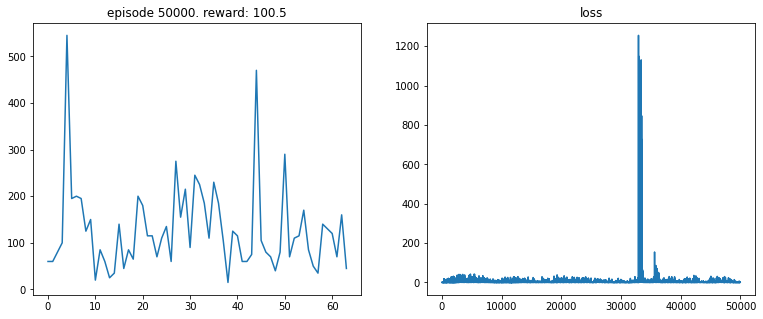

In [31]:
current_model, target_model, all_rewards, losses = train_DoubleDQN(env, current_model, target_model, eps_by_episode, optimizer, replay_buffer, episodes = 50000, batch_size=32, gamma = 0.99)

In [32]:
play_game_CNN(current_model)
time.sleep(3)
env.close()

## Dueling DQN or the real DDQNs

When you think about dueling, it must be Dread Pirate Roberts and Enigo Montoya...

<img src="img/princess-bride.png" title="" style="width: 600px;" />

Oops!!! sorry, just kidding ;P

### What is DDQNs?

To see the details, read the [Dueling DQNs (DDQNs) paper](https://arxiv.org/abs/1511.06581).

DDQNs are different from the double DQNs. Both variations assume some form of duality,
but while double DQN has two separate models, the DDQN is one model split at the base.

<img src="img/RL2_DDQN3.png" title="" style="width: 800px;" />

DDQN extends the concept of a fixed Q target and extends that to a concept called *advantage*.
The advantage indicates what additional value one action has against other actions.
The Q-value in DDQNs is computed with the following two functions:

$$Q(s,a)=V(s)+A(s,a)-\frac{1}{|A|}\sum_{a'=1}^{|A|} A(s,a')$$

 - $V(s)$: state-value function, the value of being in state $s$
 - $A(s,a)$: state-dependent action advantage function, estimating how much better it is to take an action $a$ than other actions $a'$ in the same state

In [33]:
class DDQN(nn.Module):
    def __init__(self, n_channel, n_action):
        super(DDQN, self).__init__()        
        
        self.conv1 = nn.Conv2d(in_channels=n_channel, out_channels=32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)
        
        # advantage layer: output is n_action as usual
        self.advantage = nn.Sequential(
            nn.Linear(7*7*64, 128),
            nn.ReLU(),
            nn.Linear(128, n_action)
        )
        
        # policy value: value action
        self.value = nn.Sequential(
            nn.Linear(7*7*64, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        x = x.view(x.size(0), -1)
        advantage = self.advantage(x)
        value     = self.value(x)

        # recalculate Q-value
        return value + advantage - advantage.mean()
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = autograd.Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True).to(device)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].item()
        else:
            action = random.randrange(env.action_space.n)
        return action

In [34]:
env_id = 'SpaceInvaders-v0'
env = gym.make(env_id)

current_model = DDQN(3, env.action_space.n).to(device)
target_model = DDQN(3, env.action_space.n).to(device)

optimizer = optim.Adam(current_model.parameters())
replay_buffer = ReplayBuffer(1000)

update_target(current_model, target_model)

Agent training (episode50001) Avg Reward 0.21579568408631827: 100%|██████████| 50001/50001 [05:59<00:00, 139.28it/s]


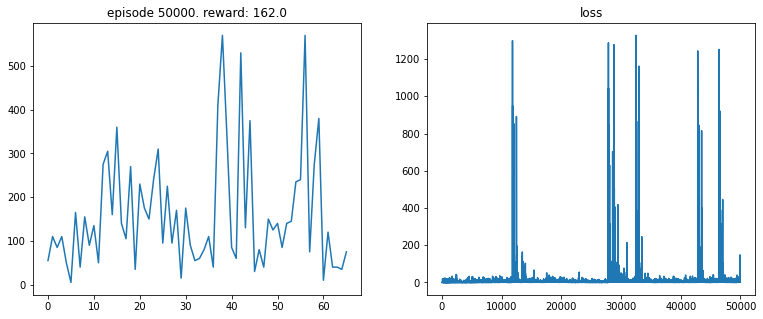

In [35]:
current_model, target_model, all_rewards, losses = train_DoubleDQN(env, current_model, target_model, eps_by_episode, optimizer, replay_buffer, episodes = 50000, batch_size=32, gamma = 0.99)

In [36]:
play_game_CNN(current_model)
time.sleep(3)
env.close()

## Prioritized experience replay

The replay buffer or experience replay mechanism allows us to values in batches at a later time in order to train the network.
Up till now, our batches are random samples from the buffer.
However, some samples would be better than others, so we don't need to store everything. We can make two decisions:
 - What data to store
 - What priority to use

Let's develop a version of the replay buffer that tracks priority from experience replay,
so we can predict where the agent should spend its learning capacity.

In [37]:
class NaivePrioritizedBuffer(object):
    def __init__(self, capacity, prob_alpha=0.6):
        self.prob_alpha = prob_alpha
        self.capacity   = capacity
        self.buffer     = []
        self.pos        = 0
        self.priorities = np.zeros((capacity,), dtype=np.float32)
    
    def push(self, state, action, reward, next_state, done):
        assert state.ndim == next_state.ndim
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        
        # check maximum priority
        max_prio = self.priorities.max() if self.buffer else 1.0
        
        # add it or replace it
        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
        else:
            self.buffer[self.pos] = (state, action, reward, next_state, done)
        
        self.priorities[self.pos] = max_prio
        self.pos = (self.pos + 1) % self.capacity
    
    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.pos]
        
        # calculate priority
        probs  = prios ** self.prob_alpha
        probs /= probs.sum()
        
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        
        total    = len(self.buffer)
        weights  = (total * probs[indices]) ** (-beta)
        weights /= weights.max()
        weights  = np.array(weights, dtype=np.float32)
        
        batch       = list(zip(*samples))
        states      = np.concatenate(batch[0])
        actions     = batch[1]
        rewards     = batch[2]
        next_states = np.concatenate(batch[3])
        dones       = batch[4]
        
        return states, actions, rewards, next_states, dones, indices, weights
    
    def update_priorities(self, batch_indices, batch_priorities):
        for idx, prio in zip(list(batch_indices), [batch_priorities]):
            self.priorities[idx] = prio

    def __len__(self):
        return len(self.buffer)

### Importance-sampling

Here we define a value $\beta$ indicating the importance of experience, focusing more on the recent experience
than on outdated experience:


In [38]:
episodes = 200000
batch_size = 64
gamma      = 0.99
min_play_reward = -.15

epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = episodes / 10
eps_by_episode = gen_eps_by_episode(epsilon_start, epsilon_final, epsilon_decay)

# defind a function to return an increasing beta over episodes
beta_start = 0.4
beta_episodes = episodes / 10
def gen_beta_by_episode(beta_start, beta_episodes):
    beta_by_episode = lambda episode: min(1.0, beta_start + episode * (1.0 - beta_start) / beta_episodes)
    return beta_by_episode

beta_by_episode = gen_beta_by_episode(beta_start, beta_episodes)

In [39]:
env_id = 'SpaceInvaders-v0'
env = gym.make(env_id)

current_model = DDQN(3, env.action_space.n).to(device)
target_model  = DDQN(3, env.action_space.n).to(device)

optimizer = optim.Adam(current_model.parameters())

# Change from Normal replay buffer to be prioritize buffer
#replay_buffer = ReplayBuffer(100000)
replay_buffer = NaivePrioritizedBuffer(100000)

update_target(current_model, target_model)

In [40]:
def compute_td_loss_DDQN_prior_exp_replay(current_model, target_model, batch_size, gamma=0.99, beta=0.4):
    # get data from replay mode
    # state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    state, action, reward, next_state, done, indices, weights = replay_buffer.sample(batch_size, beta)

    # convert to tensors
    # Autograd automatically supports Tensors with requires_grad set to True.
    state      = autograd.Variable(torch.FloatTensor(np.float32(state))).to(device)
    next_state = autograd.Variable(torch.FloatTensor(np.float32(next_state)), volatile=True).to(device)
    action     = autograd.Variable(torch.LongTensor(action)).to(device)
    reward     = autograd.Variable(torch.FloatTensor(reward)).to(device)
    done       = autograd.Variable(torch.FloatTensor(done)).to(device)
    weights    = autograd.Variable(torch.FloatTensor(weights)).to(device)

    # calculate q-values and next q-values from deeplearning
    q_values      = current_model(state)
    next_q_values = current_model(next_state)
    # double DQN add here
    #next_q_state_values = target_model(next_state)

    # get q-value from propagated action in each step
    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    # double DQN different here
    #next_q_value     = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    # calculate expected q-value from q-function
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    # calculate loss value
    # loss = (q_value - autograd.Variable(expected_q_value.data)).pow(2).mean()
    loss = (q_value - expected_q_value.detach()).pow(2).mean()
    prios = loss + 1e-5
    loss  = loss.mean()
        
    optimizer.zero_grad()
    loss.backward()
    replay_buffer.update_priorities(indices, prios.data.cpu().numpy())
    optimizer.step()

    return loss

In [41]:
def train_DDQN_prior_exp_replay(env, current_model, target_model, eps_by_episode, optimizer, replay_buffer, beta_by_episode, episodes = 10000, batch_size=32, gamma = 0.99, min_play_reward=-.15):
    losses = []
    all_rewards = []
    episode_reward = 0

    obs = env.reset()
    state = get_state2(obs)
    tot_reward = 0
    tr = trange(episodes+1, desc='Agent training', leave=True)
    for episode in tr:
        avg_reward = tot_reward / (episode + 1)
        tr.set_description("Agent training (episode{}) Avg Reward {}".format(episode+1,avg_reward))
        tr.refresh() 

        # get action with q-values
        epsilon = eps_by_episode(episode)
        action = current_model.act(state, epsilon)
        
        # input action into state
        next_obs, reward, done, _ = env.step(action)
        next_state = get_state2(next_obs)
        # save data into buffer
        replay_buffer.push(state, action, reward, next_state, done)

        tot_reward += reward
        
        state = next_state
        obs = next_obs
        episode_reward += reward
        
        if done:
            obs = env.reset()
            state = get_state2(obs)
            all_rewards.append(episode_reward)
            episode_reward = 0
            
        if len(replay_buffer) > batch_size:
            beta = beta_by_episode(episode)
            loss = compute_td_loss_DDQN_prior_exp_replay(current_model, target_model, batch_size, gamma, beta)
            losses.append(loss.item())

        if episode % 500 == 0:
            update_target(current_model, target_model)
            
    plot(episode, all_rewards, losses)  
    return current_model, target_model, all_rewards, losses

Agent training (episode200001) Avg Reward 0.269398653006735: 100%|██████████| 200001/200001 [30:55<00:00, 107.77it/s]


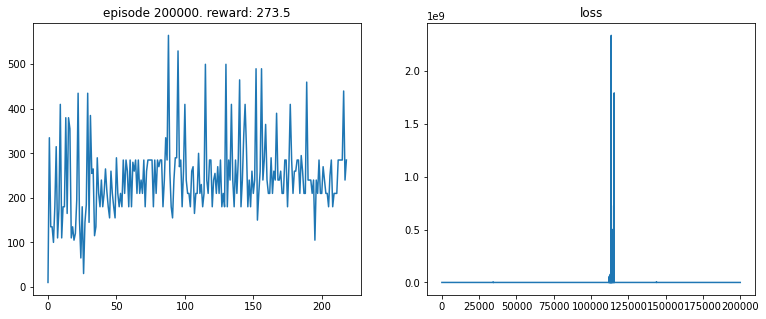

In [42]:
current_model, target_model, all_rewards, losses = train_DDQN_prior_exp_replay(env, current_model, target_model, eps_by_episode, optimizer, replay_buffer, beta_by_episode, episodes = episodes, batch_size=batch_size, gamma = gamma, min_play_reward = min_play_reward)

In [45]:
play_game_CNN(current_model)
time.sleep(3)
env.close()

If you want to try more games, go ahead...

## Independent exercise

Recall that Mnih et al. (2015) obtained superhuman playing ability for some of the Atari games by combining DQN with
experience replay and a more sophisticated state representation that what we've seen so far: they stack successive
frames as the input state representation so as to give the agent some "velocity" input rather than a static snapshot
of the scene.

Try combining the techniques we've developed in the lab with the frame history as state, and get the best Space Invaders player you can.
What's your agent's average and best score over 100 games?
